%%latex
\tableofcontents

In [26]:
import time
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import random
import csv
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor 
import matplotlib.cm as cm
# Own scripts:
%load_ext autoreload
%autoreload 2
import physics
import data
import nnc2p
# from nnc2p import NeuralNetwork # our own architecture
# Get dirs
import os
cwd = os.getcwd()# "Code" folder
master_dir = os.path.abspath(os.path.join(cwd, ".."))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Own neural network architecture defined here: (note: when put in the script, it gives errors and the notebook has to be reloaded sometimes)

In [2]:
class NeuralNetwork(nn.Module):
    """
    Implements a two-layered neural network for the C2P conversion. Note that hence the number of layers is fixed
    for this NN subclass! The activation functions are sigmoids.
    """
    def __init__(self, name: str = "network", h1: int = 600, h2: int = 200, reg: bool = False) -> None:
        """
        Initialize the neural network class.
        :param name: String that names this network, in order to recognize it later on.
        :param h1: Size (number of neurons) of the first hidden layer.
        :param h2: Size (number of neurons) of the second hidden layer.
        """
        # Call the super constructor first
        super(NeuralNetwork, self).__init__()
        
        # For convenience, save the sizes of the hidden layers as fields as well
        self.h1 = h1
        self.h2 = h2

        # Add field to specify whether or not we do regularization
        self.regularization = reg
        self.name = name

        # Define the weights:
        self.linear1 = nn.Linear(3, h1)
        self.linear2 = nn.Linear(h1, h2)
        self.linear3 = nn.Linear(h2, 1)

        # Network uses sigmoid activation functions. Input has size 3 (D, S, tau) and returns the pressure.
        # previous code:
        # self.stack = nn.Sequential(
        #     nn.Linear(3, h1),
        #     nn.Sigmoid(),
        #     nn.Linear(h1, h2),
        #     nn.Sigmoid(),
        #     nn.Linear(h2, 1)
        # )

    # TODO - what is input type here?
    def forward(self, x):
        """
        Computes a forward step given the input x.
        :param x: Input for the neural network.
        :return: x: Output neural network
        """

        x = self.linear1(x)
        x = torch.sigmoid(x)
        x = self.linear2(x)
        x = torch.sigmoid(x)
        x = self.linear3(x)
        return x

    def load_parameters(self, state_dict):
        """
        Loads the parameters, as saved before, into this network's layers. Note: assumes 2-layer network, same size.
        Explanation: we changed the details of the neural network architecture definition to have named modules in order
        to better control the pruning methods.

        :param state_dict: A state_dict containing parameters.
        :return: None
        """

        # First layer
        stack_0_weight = state_dict['stack.0.weight']
        stack_0_bias   = state_dict['stack.0.bias']
        self.linear1.weight = nn.parameter.Parameter(stack_0_weight)
        self.linear1.bias  = nn.parameter.Parameter(stack_0_bias)

        # Second layer
        stack_2_weight = state_dict['stack.2.weight']
        stack_2_bias = state_dict['stack.2.bias']
        self.linear2.weight = nn.parameter.Parameter(stack_2_weight)
        self.linear2.bias = nn.parameter.Parameter(stack_2_bias)

        # Third layer
        stack_4_weight = state_dict['stack.4.weight']
        stack_4_bias = state_dict['stack.4.bias']
        self.linear3.weight = nn.parameter.Parameter(stack_4_weight)
        self.linear3.bias = nn.parameter.Parameter(stack_4_bias)


__TODO__ - get relative paths

# Introduction

We have trained model which is succesful in the C2P conversion based on the paper by Dieselhorst et al., and this neural network is called NNC2Pv0. We trained it a bit longer compared to the paper, and ended up with an efficient network called `NNC2Pv0t2`. Naturally, we want to improve on these methods. One possibility is __pruning the neural network__ to speed up the computations.

Load a previously trained model:

In [17]:
device = "cpu"

In [18]:
model_dict = torch.load("NNC2P_new.pth")
model = nnc2p.create_nn(model_dict)
print(model)

NeuralNetwork(
  (linear1): Linear(in_features=3, out_features=600, bias=True)
  (linear2): Linear(in_features=600, out_features=200, bias=True)
  (linear3): Linear(in_features=200, out_features=1, bias=True)
)


In [19]:
# Test inference: result should be: 12.866371154785156
test = torch.tensor([10.204131145455385, 12.026584842282125, 22.131296926293793])
print(model(test).item())

12.866371154785156


What is the performance of this network?

In [20]:
_, _, _ = nnc2p.measure_performance(model, nnc2p.TEST_DATA, verbose=True)

Errors: 2.623259e-04  with L1, 1.990974e-07  with L2 and 8.344986e-03 with Linfty


Note to self: state_dict looks like: `<layer_name>.weight` et cetera

# Own pruning methods

## The main pruning loop

In [108]:
# Create most recent pruned model
pruned_dict = torch.load('pruned_most_recent.pth')
pruned = nnc2p.create_nn(pruned_dict)
to_prune = pruned
to_prune

NeuralNetwork(
  (linear1): Linear(in_features=3, out_features=584, bias=True)
  (linear2): Linear(in_features=584, out_features=137, bias=True)
  (linear3): Linear(in_features=137, out_features=1, bias=True)
)

In [22]:
# # Prune N times the model
# N = 100
# test = nnc2p.hill_climbing_pruning(to_prune, N, lr = 1e-6, nb_of_train_epochs = 100, l2_threshold = 3e-7)

# Pruning loop analysis

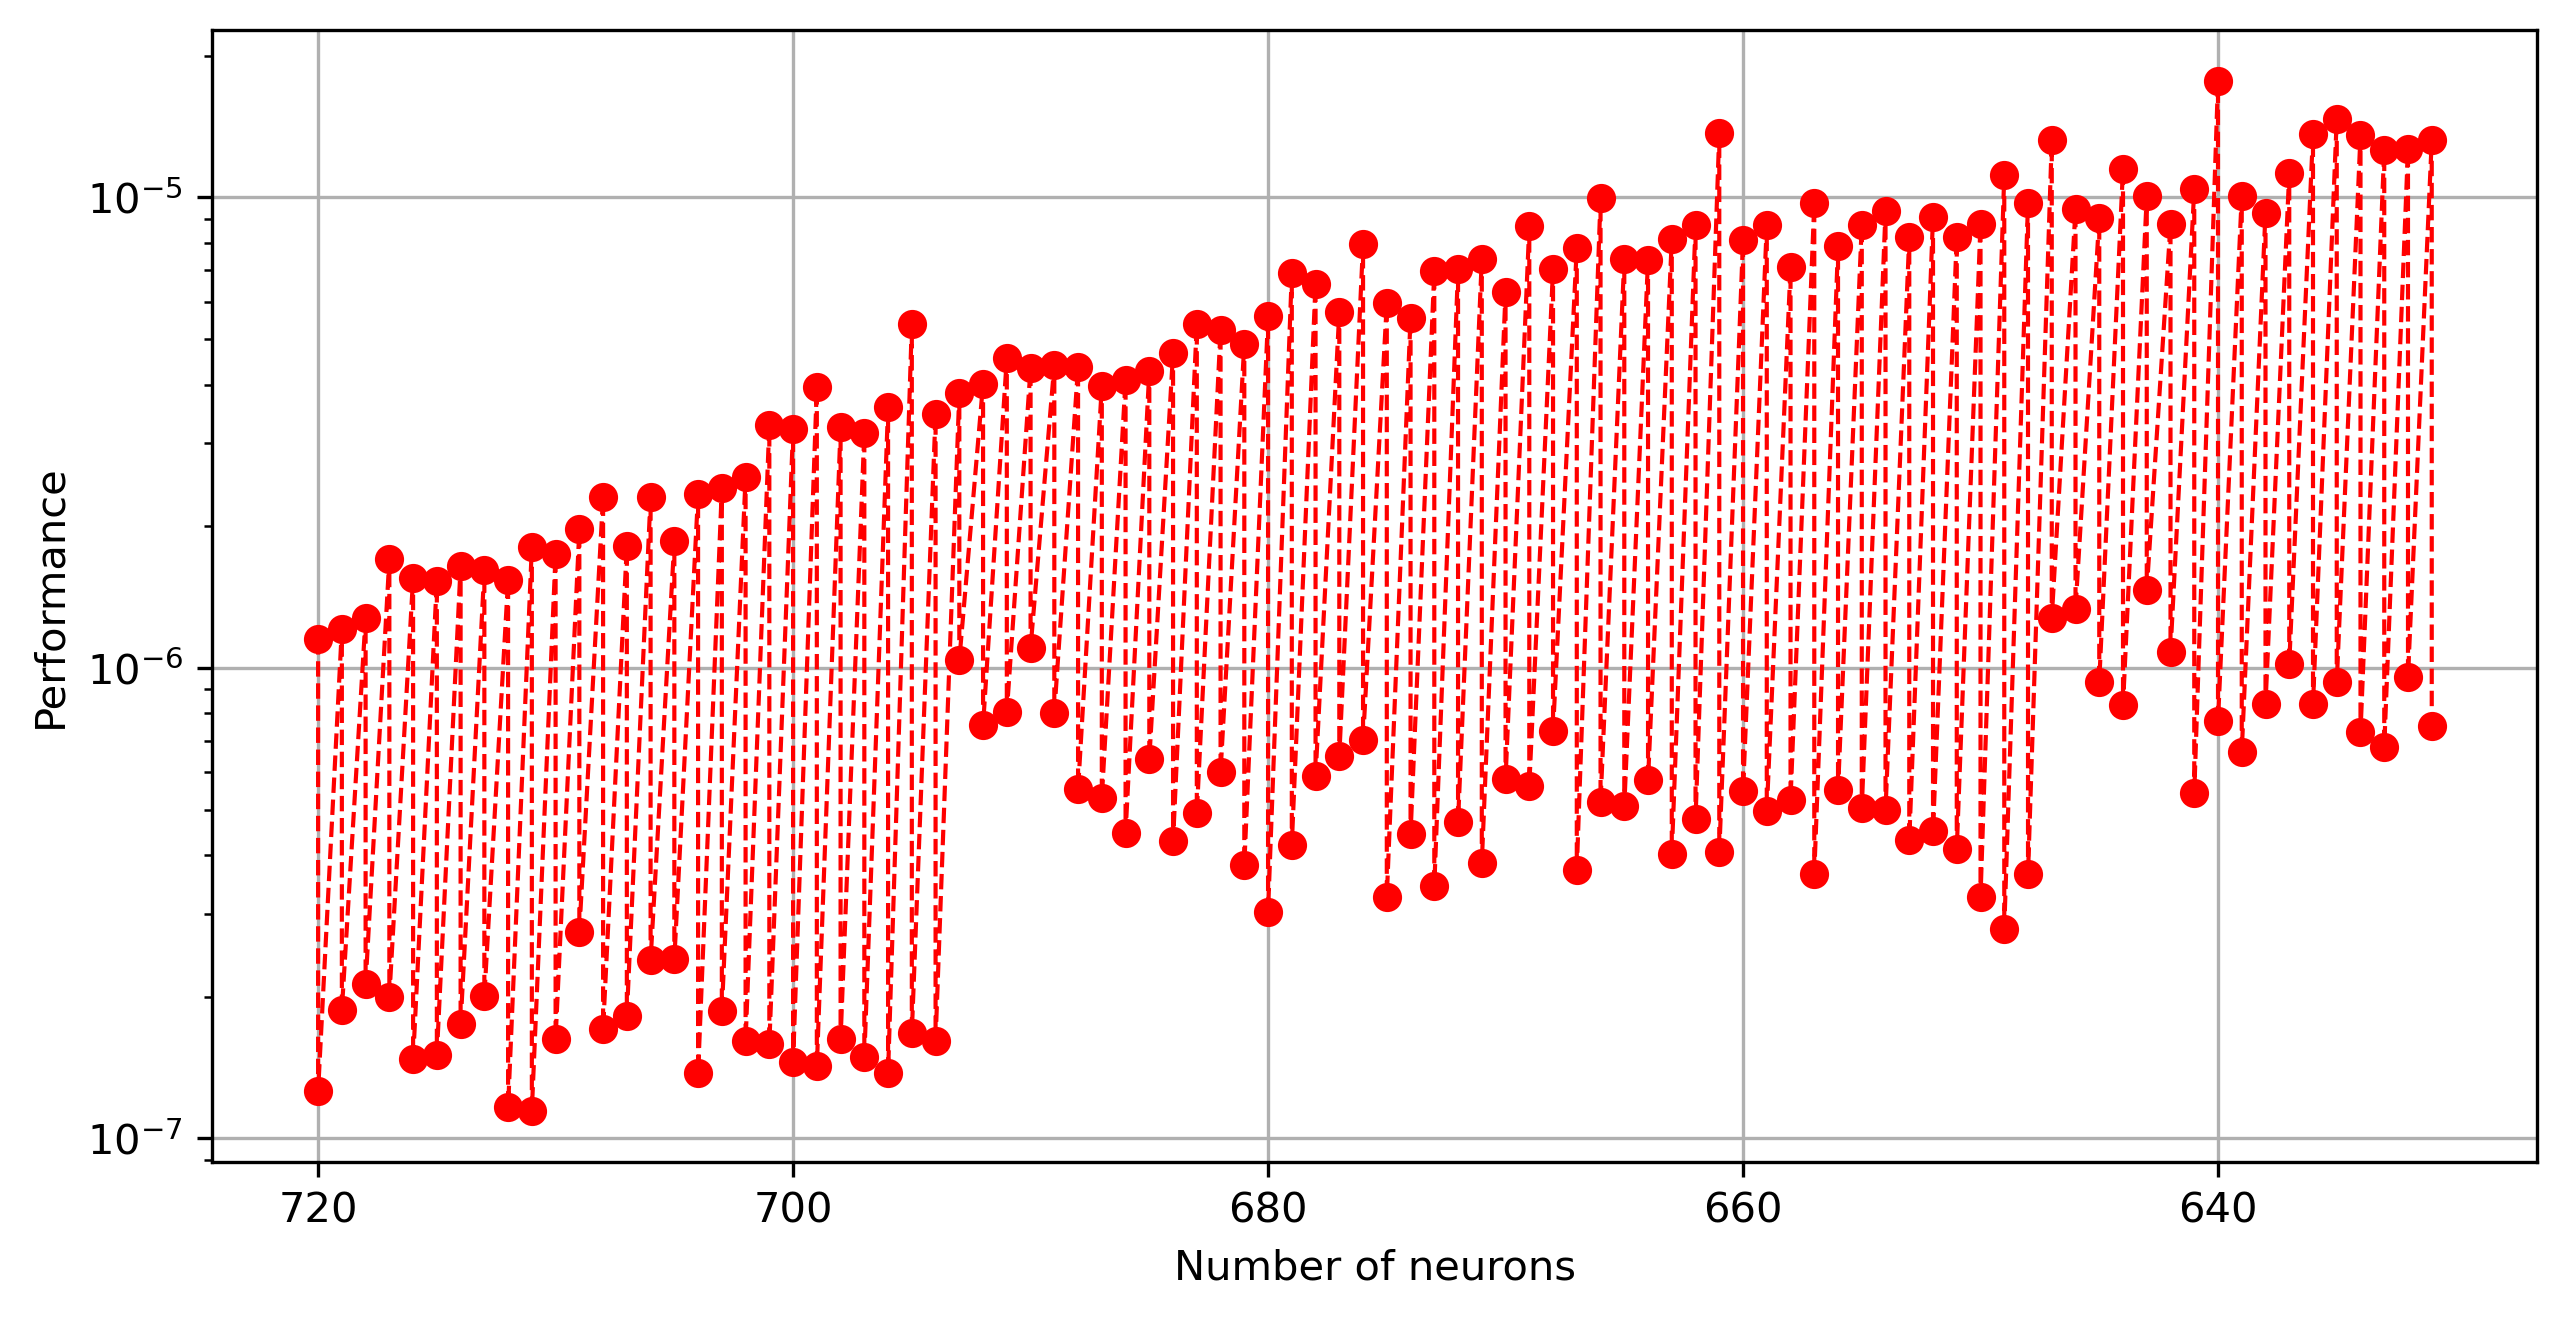

In [82]:
plt.figure(figsize=(10, 5))
df = pd.read_csv("Pruning_4/log.csv")
# Plot it
nb_of_neurons = 721 - df['counter']
plt.plot(nb_of_neurons, df['performance'], '--o', lw=1, color='red')
plt.grid()
plt.yscale('log')
plt.xlabel("Number of neurons")
plt.ylabel("Performance")
# plt.title("Pruning loop: 721 to 631")
plt.gca().invert_xaxis()
plt.savefig(os.path.join(master_dir, "Plots/pruning_4_loop_performance.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(master_dir, "Plots/pruning_4_loop_performance.png"), bbox_inches='tight')
plt.show()

Plot the final training

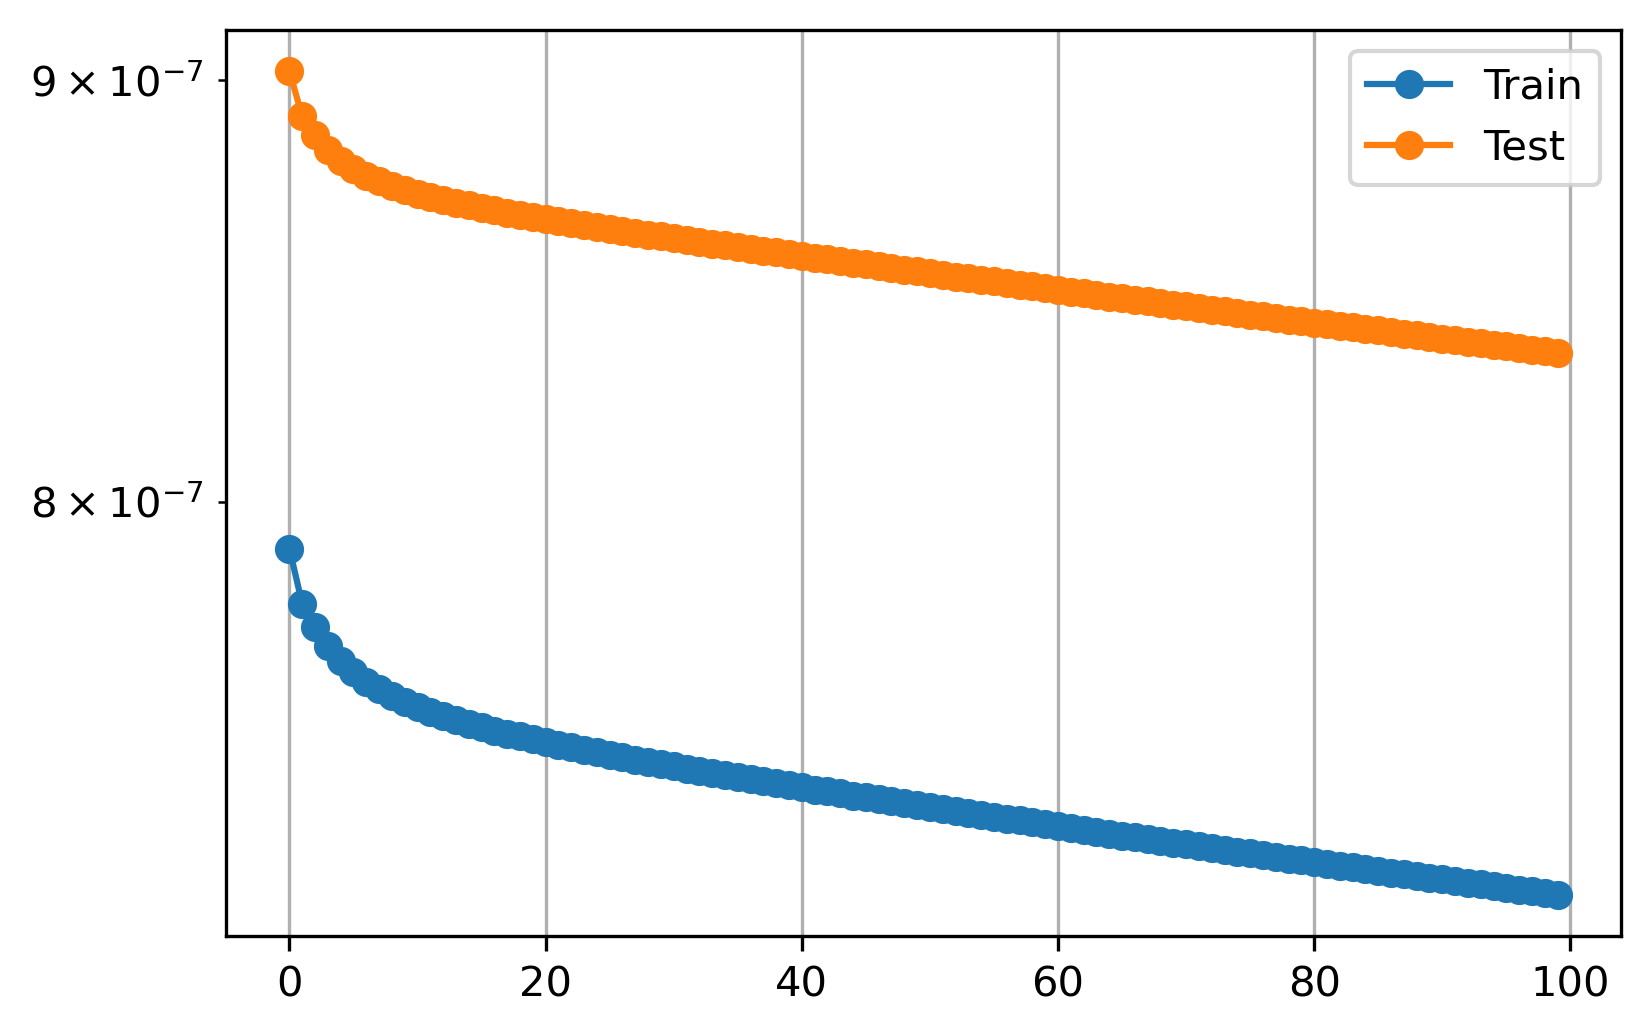

In [127]:
df = pd.read_csv("Pruning_4/training_log90.csv")
plt.plot(df['epoch'], df['train_loss'], '-o', label="Train")
plt.plot(df['epoch'], df['test_loss'], '-o', label="Test")
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

What does the latest model look like?

In [93]:
# Load the models
nets = [model]
names = ['Pruning_1', 'Pruning_3', 'Pruning_4']
for name in names:    
    pruned_dict = torch.load(name + "/pruned.pth")
    pruned = nnc2p.create_nn(pruned_dict)
    nets.append(pruned)

Compare performance of networks

In [95]:
test = nnc2p.evaluate_models(nets)
test

,h1,h2,N,l1,l2,linfty,nb_params,compression_ratio
0,600,200,800,0.000262,1.825084e-07,0.006080,122801,1.000000
1,593,138,731,0.000323,2.196025e-07,0.006538,84483,0.687967
2,584,137,721,0.000217,1.455046e-07,0.006601,82619,0.672788
3,504,127,631,0.000415,6.592631e-07,0.010113,66279,0.539727


In [138]:
most_pruned_dict = torch.load("Pruning_4/pruned.pth")
most_pruned = nnc2p.create_nn(most_pruned_dict)
most_pruned

NeuralNetwork(
  (linear1): Linear(in_features=3, out_features=504, bias=True)
  (linear2): Linear(in_features=504, out_features=127, bias=True)
  (linear3): Linear(in_features=127, out_features=1, bias=True)
)

# Evaluation of pruning method

In the following, we compare the results of finding the most optimal neuron to prune for the original NNC2P architecture, as compared to the most pruned architecture which has 630 neurons. This is to evaluate our pruning method, as it is likely that the concept of "least important neuron" loses its significance the more we prune.

In [46]:
# Get models
original = model
most_pruned_dict = torch.load("Pruning_4/pruned.pth")
most_pruned = nnc2p.create_nn(most_pruned_dict)

In [38]:
## Get optimal neuron to prune for original and most pruned networks

# print(f"Most pruned model has {most_pruned.h1 + most_pruned.h2} neurons in total")
# _, _, _, first_dict = nnc2p.find_optimal_neuron_to_prune(original)
# first_df = pd.DataFrame.from_dict(first_dict)
# _, _, _, second_dict = nnc2p.find_optimal_neuron_to_prune(most_pruned)
# second_df = pd.DataFrame.from_dict(second_dict)
## They are saved into the Data folder, optimal_neuron_to_prune_original.csv and optimal_neuron_to_prune_pruned.csv

In [39]:
first_df = pd.read_csv(os.path.join(master_dir, "Data/optimal_neuron_to_prune_original.csv"))
second_df = pd.read_csv(os.path.join(master_dir, "Data/optimal_neuron_to_prune_pruned.csv"))

## Make plots of optimal neuron to prune

### Absolute performance value

Original network

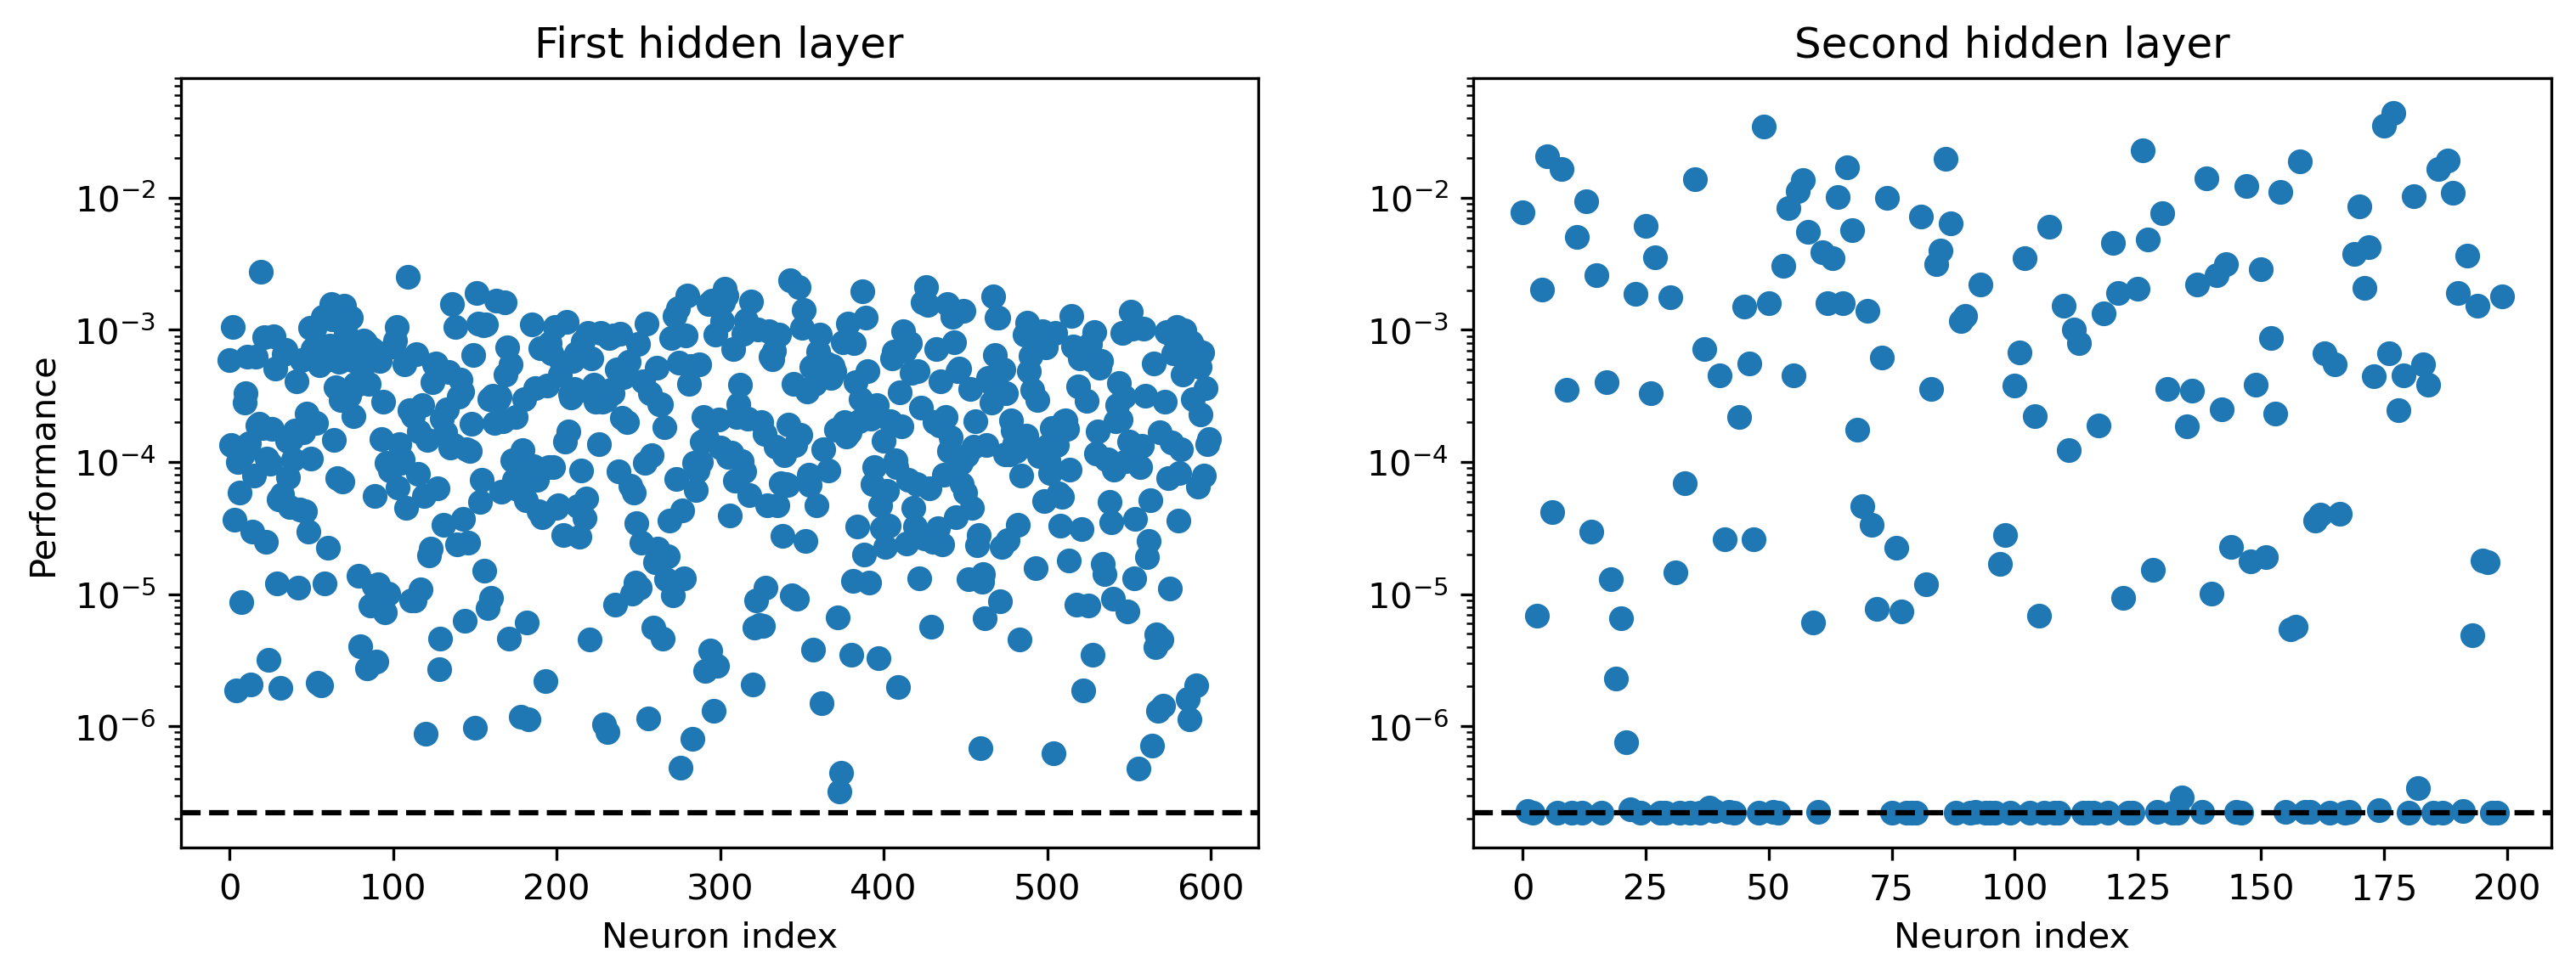

In [69]:
# Choose network and data to plot
df = first_df; net = original

# Plotting code here:
plt.figure(figsize=(12,4))
_, baseline, _ = nnc2p.measure_performance_size(net)
plt.subplot(121)
layer = df[df["layer_index"] == 1]
plt.plot(layer["neuron_index"], layer["l2_norm"], 'o')
plt.title("First hidden layer")
plt.axhline(baseline, ls='--', color='black')
plt.yscale('log')
plt.xlabel("Neuron index")
plt.ylabel("Performance")
plt.subplot(122, sharey = plt.subplot(121))
layer = df[df["layer_index"] == 2]
plt.plot(layer["neuron_index"], layer["l2_norm"], 'o')
plt.title("Second hidden layer")
plt.axhline(baseline, ls='--', color='black')
plt.yscale('log')
plt.xlabel("Neuron index")
plt.savefig(os.path.join(master_dir, "Plots/optimal_neuron_to_prune_original.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(master_dir, "Plots/optimal_neuron_to_prune_original.png"), bbox_inches='tight')
plt.show()

Pruned network:

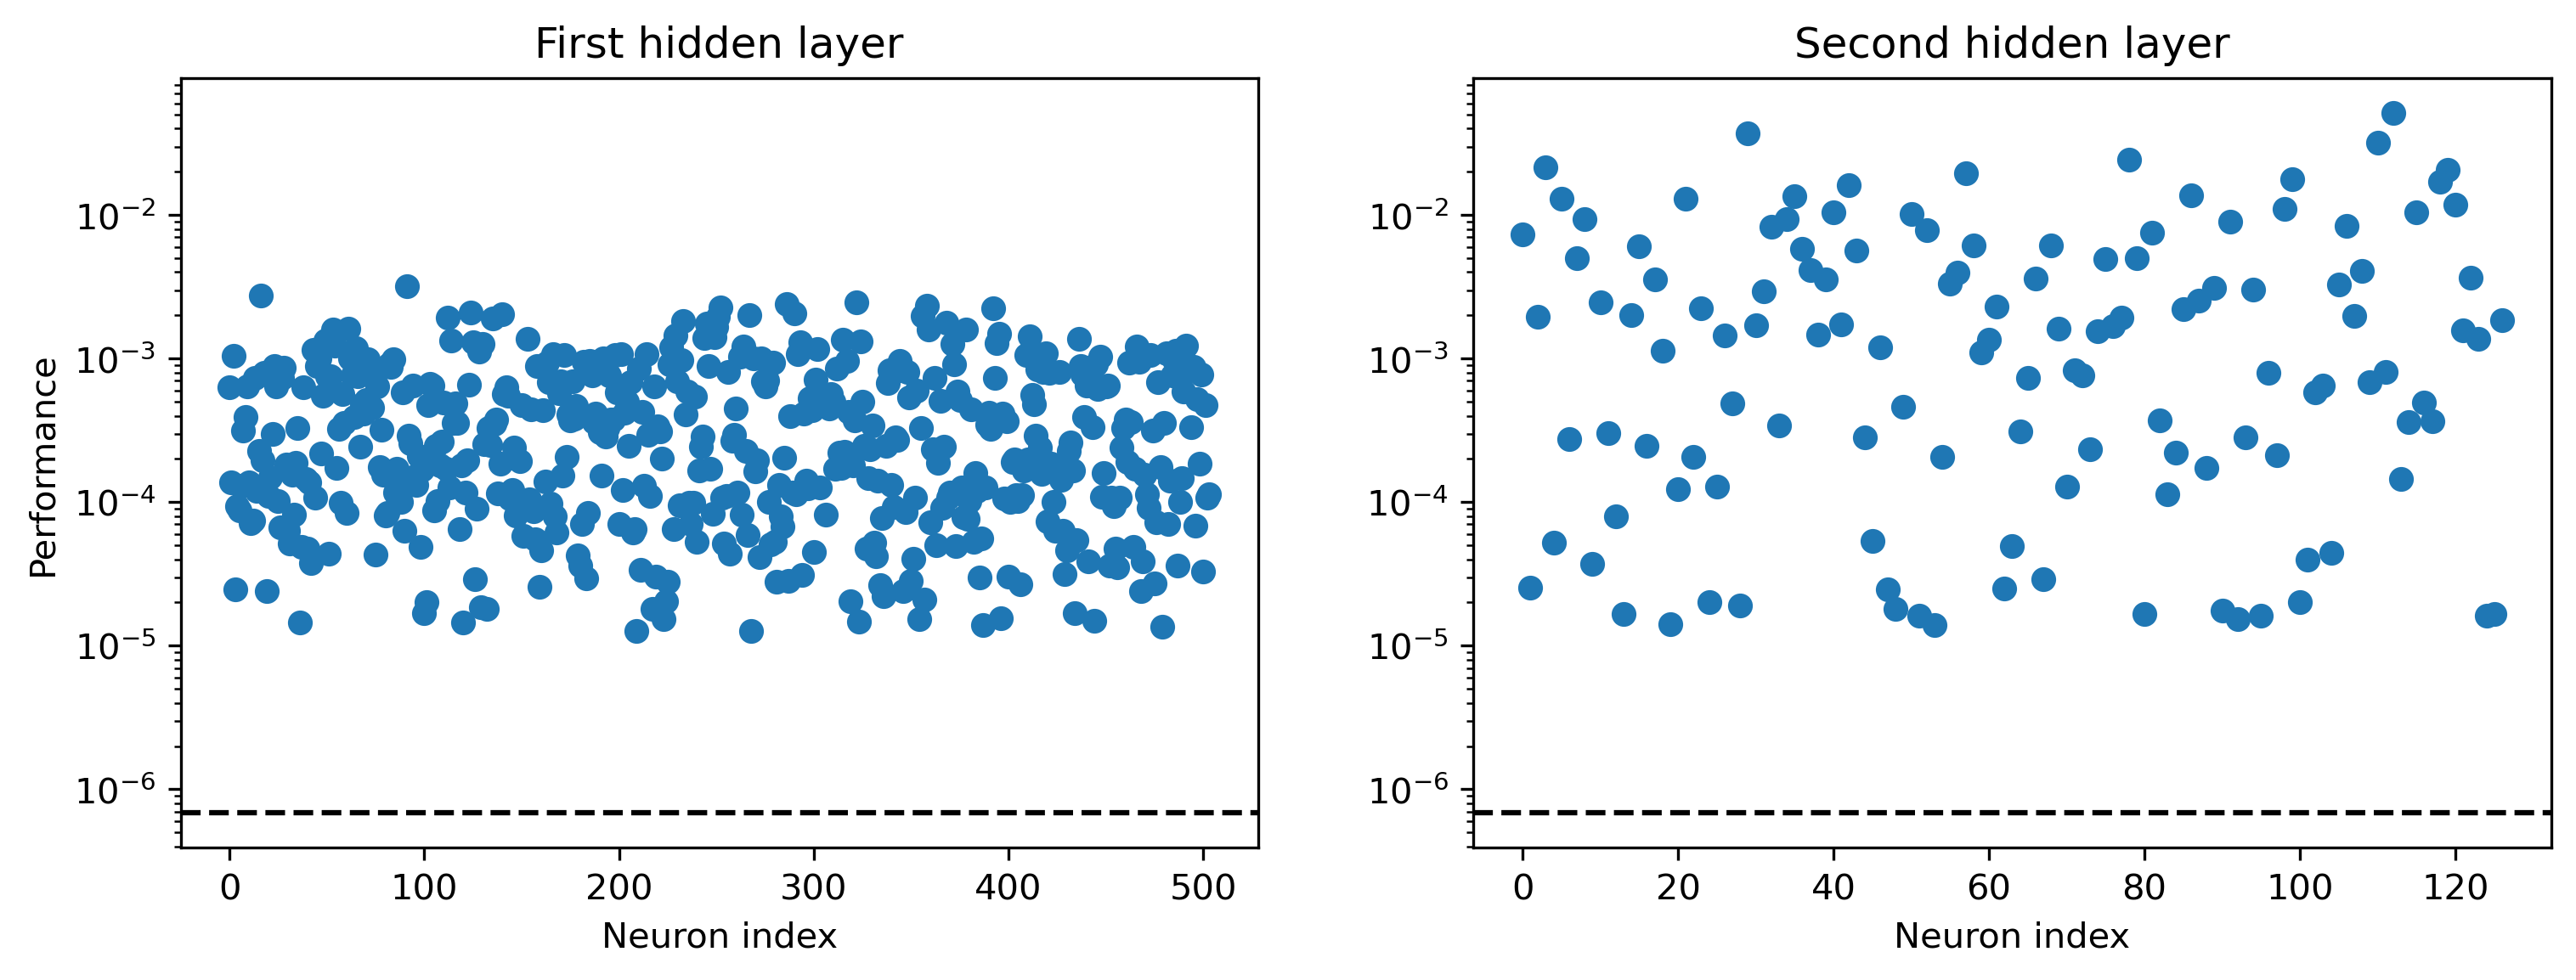

In [70]:
# Choose network and data to plot
df = second_df; net = most_pruned

# Plotting code:
plt.figure(figsize=(12,4))
_, baseline, _ = nnc2p.measure_performance_size(net)
plt.subplot(121)
layer = df[df["layer_index"] == 1]
plt.plot(layer["neuron_index"], layer["l2_norm"], 'o')
plt.title("First hidden layer")
plt.axhline(baseline, ls='--', color='black')
plt.yscale('log')
plt.xlabel("Neuron index")
plt.ylabel("Performance")
plt.subplot(122, sharey = plt.subplot(121))
layer = df[df["layer_index"] == 2]
plt.plot(layer["neuron_index"], layer["l2_norm"], 'o')
plt.title("Second hidden layer")
plt.axhline(baseline, ls='--', color='black')
plt.yscale('log')
plt.xlabel("Neuron index")
plt.savefig(os.path.join(master_dir, "Plots/optimal_neuron_to_prune_pruned.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(master_dir, "Plots/optimal_neuron_to_prune_pruned.png"), bbox_inches='tight')
plt.show()

# Further train a pruned model (if desired)

In [ ]:
pruned_dict = torch.load(os.path.join(master_dir, "Code/finetuned_most_pruned.pth"))
pruned = nnc2p.create_nn(pruned_dict)
trainer = nnc2p.Trainer(pruned, 5e-6, train_dataloader=None, test_dataloader=None)
trainer.train(log_file = "finetune_most_pruned.txt", csv_file = "finetune_most_pruned.csv")

Training the model for 500 epochs.

 Epoch 0 
 --------------
Train loss: 1.9653374400121494e-07
Test  loss: 1.932900226130788e-07

 Epoch 1 
 --------------
Train loss: 1.927236671491528e-07
Test  loss: 1.8947744519281945e-07

 Epoch 2 
 --------------
Train loss: 1.9120905498368756e-07
Test  loss: 1.8797398677435513e-07

 Epoch 3 
 --------------
Train loss: 1.9027705763576819e-07
Test  loss: 1.8706348558766193e-07

 Epoch 4 
 --------------
Train loss: 1.8955523844468303e-07
Test  loss: 1.8635863423111215e-07

 Epoch 5 
 --------------
Train loss: 1.8897963183590606e-07
Test  loss: 1.8579676317592736e-07

 Epoch 6 
 --------------
Train loss: 1.8855763687426476e-07
Test  loss: 1.853927389965328e-07

 Epoch 7 
 --------------
Train loss: 1.8807113363621396e-07
Test  loss: 1.849224007603011e-07

 Epoch 8 
 --------------
Train loss: 1.8777979818622725e-07
Test  loss: 1.8464734059822053e-07

 Epoch 9 
 --------------
Train loss: 1.875505984088477e-07
Test  loss: 1.844316431489684e-07



Train loss: 1.75086239515565e-07
Test  loss: 1.7205073110897075e-07

 Epoch 85 
 --------------
Train loss: 1.7492271224526236e-07
Test  loss: 1.71884118235668e-07

 Epoch 86 
 --------------
Train loss: 1.747634345470317e-07
Test  loss: 1.7172286528928006e-07

 Epoch 87 
 --------------
Train loss: 1.7463302883840014e-07
Test  loss: 1.7158750665975676e-07

 Epoch 88 
 --------------
Train loss: 1.745255739898255e-07
Test  loss: 1.7147926255101478e-07

 Epoch 89 
 --------------


In [116]:
trained = trainer.model
torch.save(trained.state_dict(), "finetuned_most_pruned.pth")

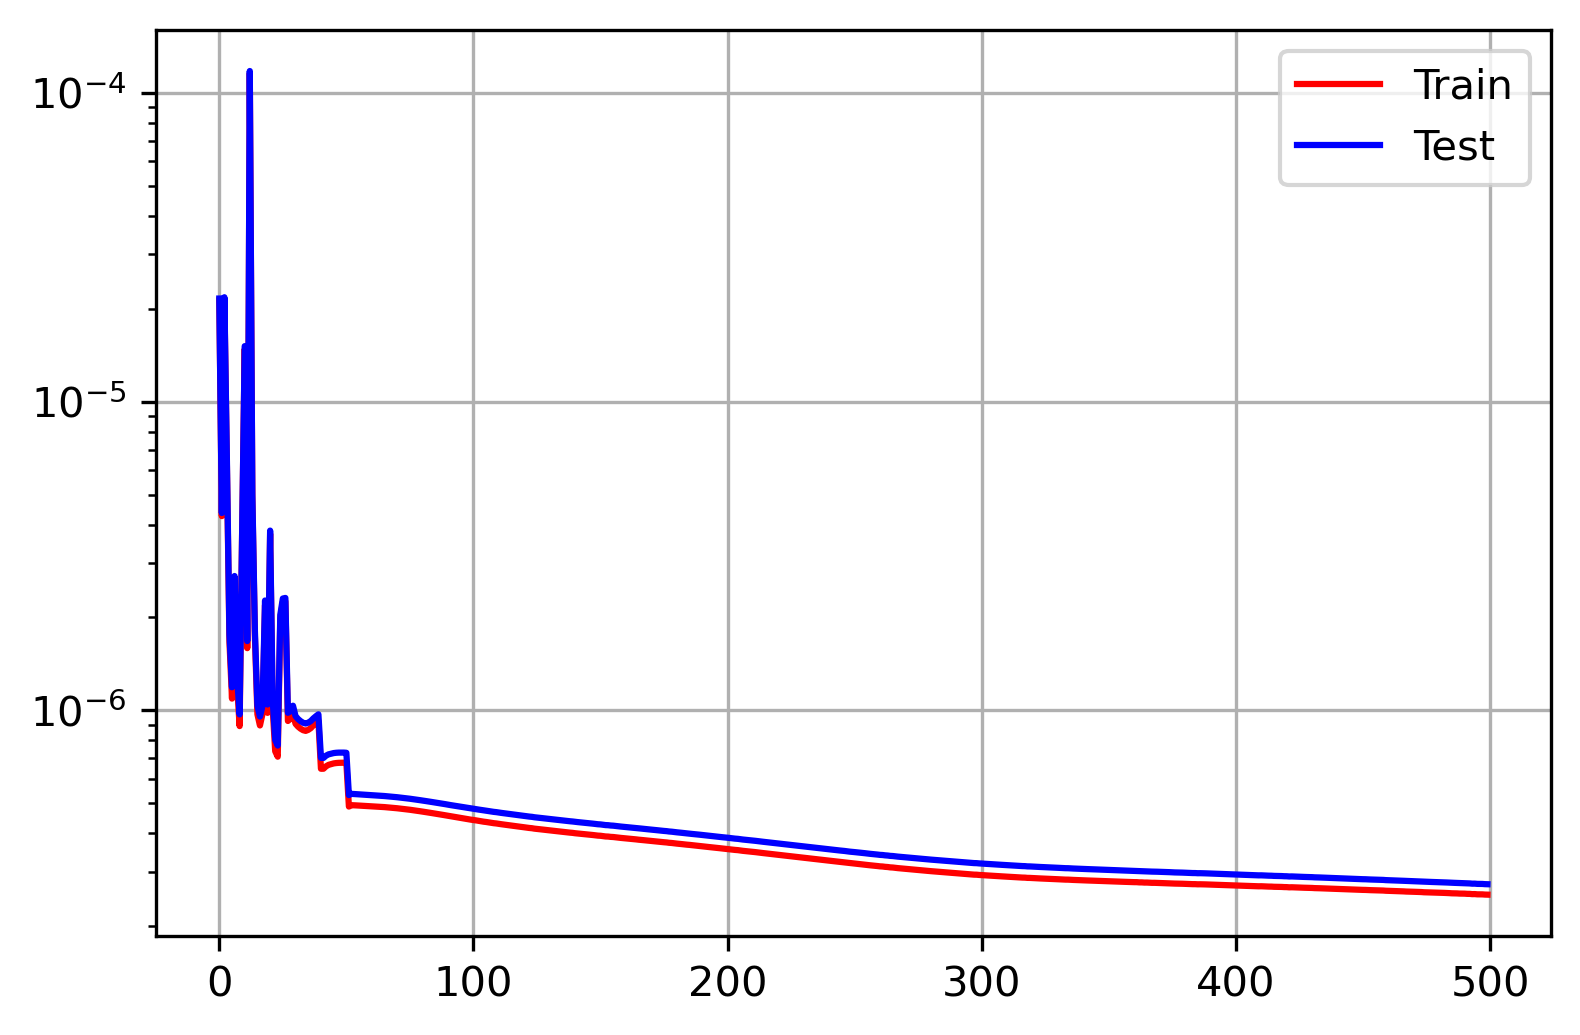

In [105]:
# df = pd.read_csv("finetune_most_pruned.csv")
plt.plot(trainer.train_losses, color='red', label="Train")
plt.plot(trainer.test_losses, color='blue', label="Test")
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

# PyTorch pruning tutorial

PyTorch has a library for pruning, see [their pruning tutorial](https://pytorch.org/tutorials/intermediate/pruning_tutorial.html).

In [27]:
import torch.nn.utils.prune as prune

For this test, we prune the second weight matrix of our network.

In [28]:
module = model.linear2
print(list(module.named_parameters()))
prune.random_unstructured(module, name="weight", amount=0.3)

[('weight', Parameter containing:
tensor([[-0.2067,  0.0381,  0.0541,  ..., -0.1053,  0.0773, -0.0022],
        [ 0.0454, -0.0570, -0.0544,  ...,  0.0199, -0.1168, -0.0555],
        [-0.0048, -0.0284, -0.0800,  ..., -0.0789, -0.0413, -0.0859],
        ...,
        [ 0.0500, -0.0569, -0.0705,  ...,  0.0048, -0.0813, -0.0858],
        [ 0.0667, -0.0904, -0.0727,  ...,  0.0317, -0.0615, -0.0056],
        [-0.1763,  0.0120,  0.0712,  ..., -0.0230,  0.0433,  0.0013]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([-0.0271, -0.0239, -0.0302, -0.0114, -0.0249,  0.0093, -0.0515, -0.0817,
         0.0342, -0.0339, -0.0481,  0.0432, -0.0191,  0.0025, -0.0540, -0.0058,
        -0.0647, -0.0440, -0.0351, -0.0593, -0.0735, -0.0544, -0.0814, -0.0214,
        -0.0154, -0.0055, -0.0674,  0.0044, -0.0351, -0.0741,  0.0171, -0.0615,
        -0.0459, -0.0020, -0.0305, -0.0228, -0.0305, -0.0376, -0.0454, -0.0744,
         0.0535, -0.0635, -0.0144, -0.0232, -0.0254,  0.0227, -0.0344, -

Linear(in_features=600, out_features=200, bias=True)

In [30]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[0., 1., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 0., 0.]]))]


Pruning acts by removing weight from the parameters and replacing it with a new parameter called weight_orig (i.e. appending "_orig" to the initial parameter name). weight_orig stores the unpruned version of the tensor. The bias was not pruned, so it will remain intact.

In [29]:
print(list(module.named_parameters()))

[('bias', Parameter containing:
tensor([-0.0271, -0.0239, -0.0302, -0.0114, -0.0249,  0.0093, -0.0515, -0.0817,
         0.0342, -0.0339, -0.0481,  0.0432, -0.0191,  0.0025, -0.0540, -0.0058,
        -0.0647, -0.0440, -0.0351, -0.0593, -0.0735, -0.0544, -0.0814, -0.0214,
        -0.0154, -0.0055, -0.0674,  0.0044, -0.0351, -0.0741,  0.0171, -0.0615,
        -0.0459, -0.0020, -0.0305, -0.0228, -0.0305, -0.0376, -0.0454, -0.0744,
         0.0535, -0.0635, -0.0144, -0.0232, -0.0254,  0.0227, -0.0344, -0.0436,
        -0.0584,  0.0099, -0.0403, -0.0387, -0.0368,  0.0166,  0.0336, -0.0221,
         0.0520, -0.0206,  0.0083, -0.0750, -0.0349, -0.0069, -0.0171,  0.0392,
         0.0177, -0.0280,  0.0325,  0.0341, -0.0005, -0.0501, -0.0515, -0.0328,
        -0.0284, -0.0531,  0.0279, -0.0303,  0.0078, -0.0676, -0.0238, -0.0261,
        -0.0792,  0.0161, -0.0640,  0.0077, -0.0182,  0.0292,  0.0060,  0.0367,
        -0.0227, -0.0028,  0.0066, -0.0860, -0.0802,  0.0037, -0.0384, -0.0578,
        

In [31]:
print(list(module.named_buffers()))

[('weight_mask', tensor([[0., 1., 0.,  ..., 0., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 0.],
        [1., 1., 0.,  ..., 1., 1., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 1., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.],
        [1., 1., 0.,  ..., 1., 0., 0.]]))]


For the forward pass to work without modification, the weight attribute needs to exist. The pruning techniques implemented in torch.nn.utils.prune compute the pruned version of the weight (by combining the mask with the original parameter) and store them in the attribute weight. Note, this is no longer a parameter of the module, it is now simply an attribute.

In [32]:
print(module.weight)

tensor([[-0.0000,  0.0381,  0.0000,  ..., -0.0000,  0.0000, -0.0022],
        [ 0.0454, -0.0000, -0.0544,  ...,  0.0199, -0.1168, -0.0000],
        [-0.0048, -0.0284, -0.0000,  ..., -0.0789, -0.0413, -0.0000],
        ...,
        [ 0.0500, -0.0569, -0.0705,  ...,  0.0000, -0.0813, -0.0858],
        [ 0.0667, -0.0000, -0.0727,  ...,  0.0317, -0.0615, -0.0056],
        [-0.1763,  0.0120,  0.0000,  ..., -0.0230,  0.0000,  0.0000]],
       grad_fn=<MulBackward0>)


# (Archive) Hyperparameter tuning

[Useful tutorial](https://machinelearningmastery.com/how-to-grid-search-hyperparameters-for-pytorch-models/)

In [11]:
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetRegressor

In [12]:
tune_model = NeuralNetRegressor(
    NeuralNetwork,
    criterion = nn.MSELoss,
    optimizer = torch.optim.Adam,
    max_epochs = 50,
    batch_size=32,
    verbose=True
)

Get the data in the correct format

In [13]:
# Load data for hyperparameter tuning
d = physics.generate_data_as_df(number_of_points = 10000)
X = torch.tensor(np.transpose([d['D'], d['S'], d['tau']]), dtype=torch.float32)
y = torch.tensor(np.transpose(d['p']), dtype=torch.float32).reshape(-1, 1)

In [14]:
# Define the grid search parameters
param_grid = {
    'optimizer__lr': [1e-5, 5e-6, 1e-6, 5e-7, 1e-7],
}
# Do grid search
grid = GridSearchCV(estimator=tune_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X, y)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1       16.6177       14.6164  1.2330
      2       11.4934       11.0546  1.9940
      3        9.1680        9.2972  1.5260
      4        7.9352        8.2480  1.1740
      5        7.1231        7.4868  0.9930
      6        6.4842        6.8558  0.9820
      7        5.9342        6.3017  1.0920
      8        5.4487        5.8081  1.2520
      9        5.0193        5.3674  1.0140
     10        4.6396        4.9739  0.9680
     11        4.3023        4.6208  0.9401
     12        3.9996        4.3009  1.0140
     13        3.7233        4.0067  0.9510
     14        3.4665        3.7319  0.9620
     15        3.2240        3.4723  0.9320
     16        2.9930        3.2252  0.9950
     17        2.7719        2.9892  0.9980
     18        2.5602        2.7639  0.9540
     19        2.3590        2.5512  0.9860
     20        2.1702        2.3529  1.0090
     21        1.9947        2.1

In [15]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.922558 using {'optimizer__lr': 1e-05}
0.922558 (0.013740) with: {'optimizer__lr': 1e-05}
0.704516 (0.007749) with: {'optimizer__lr': 5e-06}
0.134989 (0.021481) with: {'optimizer__lr': 1e-06}
-0.159365 (0.058258) with: {'optimizer__lr': 5e-07}
-0.985676 (0.247234) with: {'optimizer__lr': 1e-07}
